# Lung and Colon cancer detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing libraries

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import Model
import zipfile

# Preprocessing

Loading data set

In [7]:
with zipfile.ZipFile("/content/drive/My Drive/archive.zip", 'r') as zip_ref:
    zip_ref.extractall('/content/lung_colon_images')

file_paths_lung = []
labels_lung = []

file_paths_colon = []
labels_colon = []

lung_file_path = '/content/lung_colon_images/lung_colon_image_set/lung_image_sets'
colon_file_path = '/content/lung_colon_images/lung_colon_image_set/colon_image_sets'

lung_types = os.listdir(lung_file_path)
colon_types = os.listdir(colon_file_path)

for lung_type in lung_types:
    folder_path = os.path.join(lung_file_path, lung_type)
    list_of_files = os.listdir(folder_path)
    for file in list_of_files:
        file_path = os.path.join(folder_path, file)

        file_paths_lung.append(file_path)
        labels_lung.append(lung_type)

for colon_type in colon_types:
    folder_path = os.path.join(colon_file_path, colon_type)
    list_of_files = os.listdir(folder_path)
    for file in list_of_files:
        file_path = os.path.join(folder_path, file)

        file_paths_colon.append(file_path)
        labels_colon.append(colon_type)


lung_data_frame = pd.concat([pd.Series(file_paths_lung, name="paths"), pd.Series(labels_lung, name="labels")], axis=1)
colon_data_frame = pd.concat([pd.Series(file_paths_colon, name="paths"), pd.Series(labels_colon, name="labels")], axis=1)

print(lung_data_frame)


                                                   paths    labels
0      /content/lung_colon_images/lung_colon_image_se...  lung_aca
1      /content/lung_colon_images/lung_colon_image_se...  lung_aca
2      /content/lung_colon_images/lung_colon_image_se...  lung_aca
3      /content/lung_colon_images/lung_colon_image_se...  lung_aca
4      /content/lung_colon_images/lung_colon_image_se...  lung_aca
...                                                  ...       ...
14995  /content/lung_colon_images/lung_colon_image_se...  lung_scc
14996  /content/lung_colon_images/lung_colon_image_se...  lung_scc
14997  /content/lung_colon_images/lung_colon_image_se...  lung_scc
14998  /content/lung_colon_images/lung_colon_image_se...  lung_scc
14999  /content/lung_colon_images/lung_colon_image_se...  lung_scc

[15000 rows x 2 columns]


 Is data set balanced?

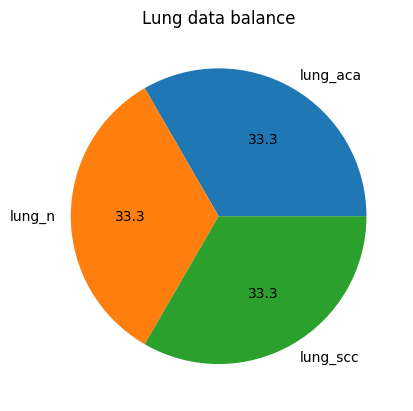

In [8]:
plt.pie(lung_data_frame.labels.value_counts(), labels = lung_data_frame.labels.value_counts().index, autopct='%1.1f')
plt.title("Lung data balance")
plt.show()

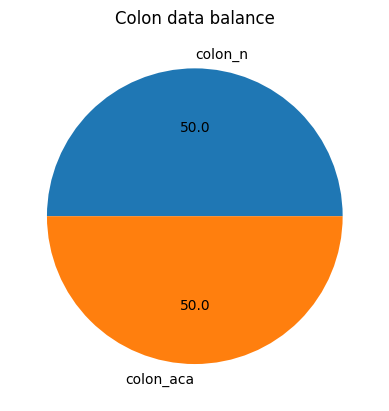

In [5]:
plt.pie(colon_data_frame.labels.value_counts(), labels = colon_data_frame.labels.value_counts().index, autopct='%1.1f')
plt.title("Colon data balance")
plt.show()

Splitting data in 3 groups: train, test and valid

In [9]:
train_df_lung, rest_lung = train_test_split(lung_data_frame, train_size=0.7, shuffle=True, random_state=123)
valid_df_lung, test_df_lung = train_test_split(rest_lung, train_size=0.5, shuffle=True, random_state=123)

In [10]:
train_df_colon, rest_colon = train_test_split(colon_data_frame, train_size=0.7, shuffle=True, random_state=123)
valid_df_colon, test_df_colon = train_test_split(rest_colon, train_size=0.5, shuffle=True, random_state=123)

Image data generator

In [11]:
batch_size = 32
img_size = (224, 224)

tr_gen_lung = ImageDataGenerator(rescale=1./255)
ts_gen_lung = ImageDataGenerator(rescale=1./255)
val_gen_lung = ImageDataGenerator(rescale=1./255)

train_gen_lung = tr_gen_lung.flow_from_dataframe(
    train_df_lung,
    x_col= 'paths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

valid_gen_lung = val_gen_lung.flow_from_dataframe(
    valid_df_lung,
    x_col= 'paths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

test_gen_lung = ts_gen_lung.flow_from_dataframe(
    test_df_lung,
    x_col= 'paths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size)

Found 10500 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.


In [12]:
tr_gen_colon = ImageDataGenerator(rescale=1./255)
ts_gen_colon = ImageDataGenerator(rescale=1./255)
val_gen_colon = ImageDataGenerator(rescale=1./255)

train_gen_colon = tr_gen_colon.flow_from_dataframe(
    train_df_colon,
    x_col= 'paths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

valid_gen_colon = val_gen_colon.flow_from_dataframe(
    valid_df_colon,
    x_col= 'paths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

test_gen_colon = ts_gen_colon.flow_from_dataframe(
    test_df_colon,
    x_col= 'paths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size)

Found 7000 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


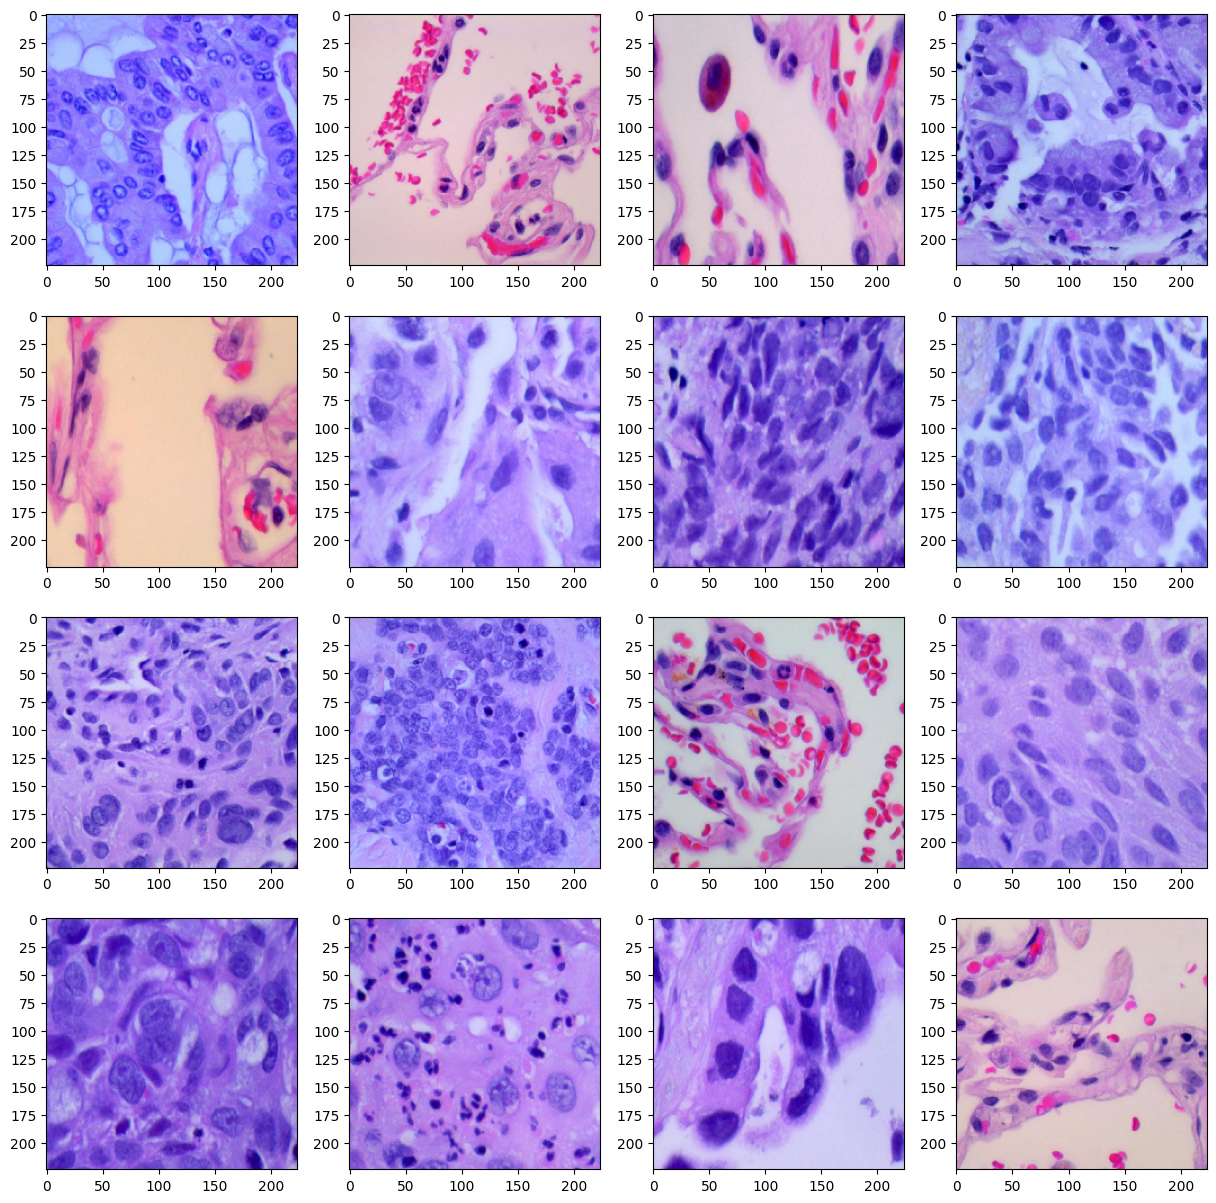

In [13]:
images, labels = next(train_gen_lung)

plt.figure(figsize= (15, 15))
for i in range(batch_size//2):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])

plt.show()

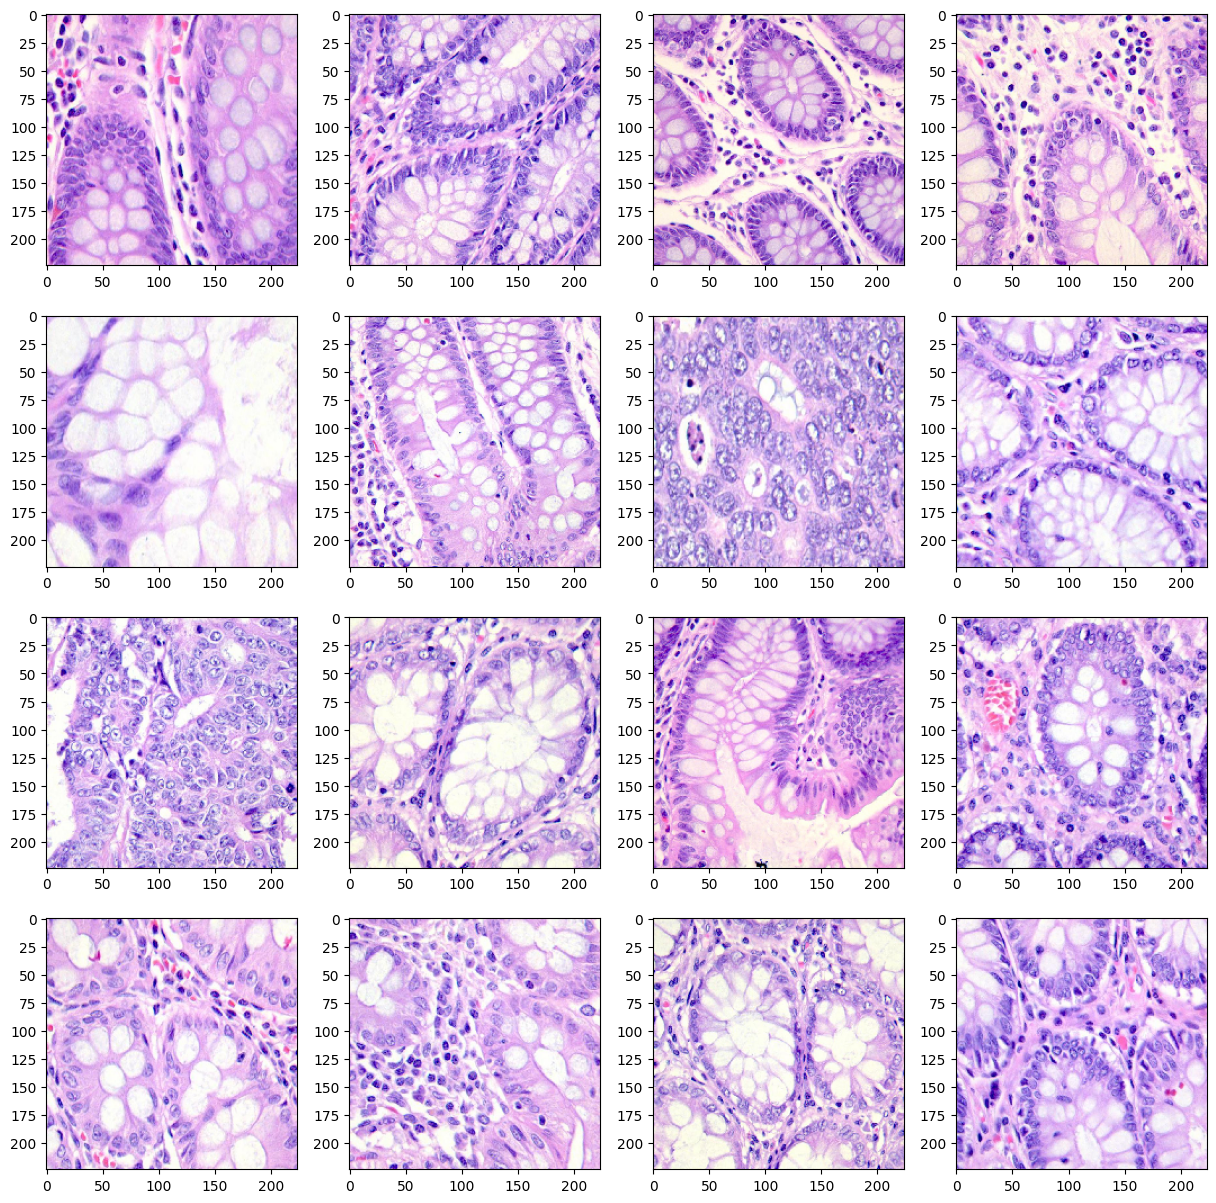

In [14]:
images, labels = next(train_gen_colon)

plt.figure(figsize= (15, 15))

for i in range(batch_size//2):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])

plt.show()

# Models

In [ ]:
model_lung = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(list(train_gen_lung.class_indices.keys())), activation='softmax')
])

model_lung.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model_lung.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                        

In [ ]:
epochs = 20
history_lung = model_lung.fit(train_gen_lung, epochs=epochs, verbose=1,validation_data=valid_gen_lung, shuffle=False)

Epoch 1/20
657/657 [==============================] - 69s 90ms/step - loss: 0.4873 - accuracy: 0.8367 - val_loss: 0.2112 - val_accuracy: 0.9116
Epoch 2/20
657/657 [==============================] - 58s 88ms/step - loss: 0.2666 - accuracy: 0.9017 - val_loss: 0.1419 - val_accuracy: 0.9471
Epoch 3/20
657/657 [==============================] - 61s 93ms/step - loss: 0.1972 - accuracy: 0.9287 - val_loss: 0.1429 - val_accuracy: 0.9467
Epoch 4/20
657/657 [==============================] - 57s 87ms/step - loss: 0.1744 - accuracy: 0.9373 - val_loss: 0.0935 - val_accuracy: 0.9622
Epoch 5/20
657/657 [==============================] - 57s 86ms/step - loss: 0.1209 - accuracy: 0.9559 - val_loss: 0.0665 - val_accuracy: 0.9742
Epoch 6/20
657/657 [==============================] - 59s 90ms/step - loss: 0.1044 - accuracy: 0.9644 - val_loss: 0.0653 - val_accuracy: 0.9676
Epoch 7/20
657/657 [==============================] - 54s 82ms/step - loss: 0.0802 - accuracy: 0.9721 - val_loss: 0.0432 - val_accuracy:

In [ ]:
model_lung.save("/content/lung_colon_images/model_lung_1.keras")

In [ ]:
model_lung = load_model("/content/lung_colon_images/EfficientNetB3_model_lung.keras")

In [28]:
def print_performance(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Find the best epoch based on validation loss and accuracy
    best_epoch_loss = val_loss.index(min(val_loss)) + 1
    best_epoch_acc = val_acc.index(max(val_acc)) + 1

    # Plot training and validation loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.plot(best_epoch_loss, val_loss[best_epoch_loss-1], 'go', label='Best Epoch (Val Loss)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.plot(best_epoch_acc, val_acc[best_epoch_acc-1], 'go', label='Best Epoch (Val Accuracy)')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



In [ ]:
print_performance(history_lung)

In [30]:
def print_evaluation(model, train_gen, valid_gen, test_gen):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


In [ ]:
print_evaluation(model_lung, train_gen_lung, valid_gen_lung, test_gen_lung)

In [31]:
def print_confusion_matrix(model, test_gen):
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    cm = confusion_matrix(test_gen.classes, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()




In [ ]:
print_confusion_matrix(model_lung, test_gen_lung)

In [ ]:
print(classification_report(test_gen_lung.classes, np.argmax(model_lung.predict(test_gen_lung), axis=1), target_names= list(test_gen_lung.class_indices.keys())))

In [ ]:
model_colon = Sequential()

# First convolutional layer
model_colon.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_colon.add(MaxPooling2D((2, 2)))
model_colon.add(BatchNormalization())

# Second convolutional layer
model_colon.add(Conv2D(64, (3, 3), activation='relu'))
model_colon.add(MaxPooling2D((2, 2)))
model_colon.add(BatchNormalization())

# Third convolutional layer
model_colon.add(Conv2D(128, (3, 3), activation='relu'))
model_colon.add(MaxPooling2D((2, 2)))
model_colon.add(BatchNormalization())

# Flatten the output
model_colon.add(Flatten())

# Fully connected layer
model_colon.add(Dense(128, activation='relu'))
model_colon.add(Dropout(0.5))

# Output layer
model_colon.add(Dense(2, activation='softmax'))

# Compile the model
model_colon.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model_colon.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 111, 111, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
epochs = 20
history_colon = model_colon.fit(train_gen_colon, epochs= epochs, verbose= 1, validation_data= valid_gen_colon)

Epoch 1/20
219/219 [==============================] - 51s 218ms/step - loss: 0.9664 - accuracy: 0.8949 - val_loss: 12.9580 - val_accuracy: 0.5133
Epoch 2/20
219/219 [==============================] - 41s 188ms/step - loss: 0.1624 - accuracy: 0.9624 - val_loss: 0.3758 - val_accuracy: 0.8773
Epoch 3/20
219/219 [==============================] - 41s 185ms/step - loss: 0.1198 - accuracy: 0.9714 - val_loss: 0.2028 - val_accuracy: 0.9413
Epoch 4/20
219/219 [==============================] - 42s 190ms/step - loss: 0.0532 - accuracy: 0.9827 - val_loss: 0.1605 - val_accuracy: 0.9693
Epoch 5/20
219/219 [==============================] - 43s 197ms/step - loss: 0.0507 - accuracy: 0.9857 - val_loss: 0.1860 - val_accuracy: 0.9733
Epoch 6/20
219/219 [==============================] - 41s 185ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 0.1298 - val_accuracy: 0.9773
Epoch 7/20
219/219 [==============================] - 42s 193ms/step - loss: 0.0622 - accuracy: 0.9837 - val_loss: 0.2609 - val_a

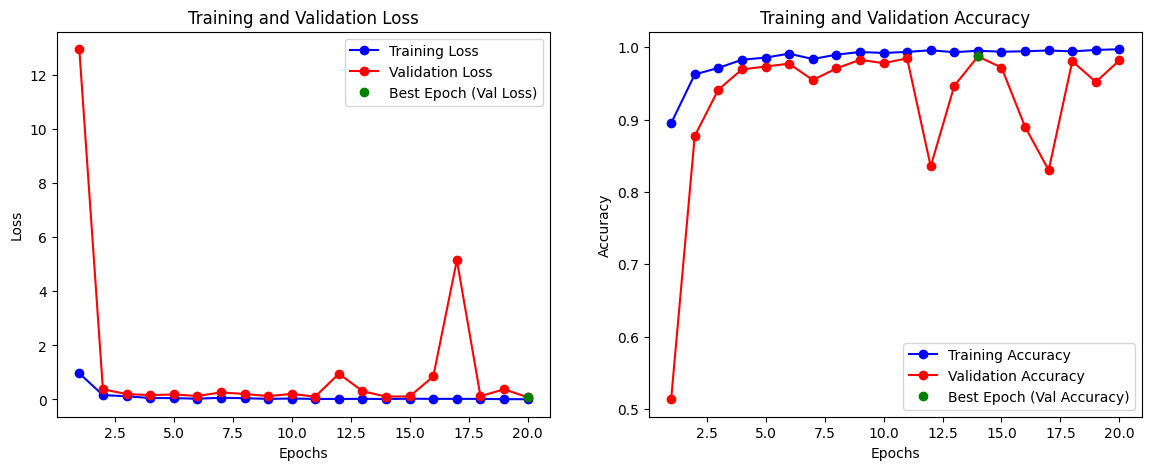

In [ ]:
print_performance(history_colon)

In [ ]:
print_evaluation(model_colon, train_gen_colon, valid_gen_colon, test_gen_colon)

47/47 [==============================] - 8s 170ms/step - loss: 0.0552 - accuracy: 0.9827
Train Loss:  0.0020703033078461885
Train Accuracy:  0.9997143149375916
--------------------
Validation Loss:  0.08223733305931091
Validation Accuracy:  0.9819999933242798
--------------------
Test Loss:  0.05517803505063057
Test Accuracy:  0.9826666712760925


47/47 [==============================] - 14s 285ms/step


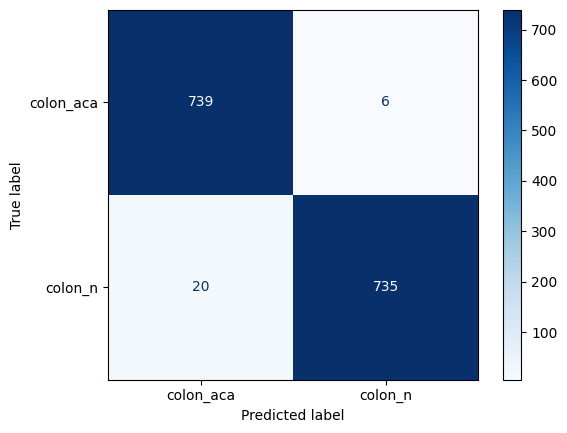

In [ ]:
print_confusion_matrix(model_colon, test_gen_colon)

In [ ]:
print(classification_report(test_gen_colon.classes, np.argmax(model_colon.predict(test_gen_colon), axis=1), target_names= list(test_gen_colon.class_indices.keys())))

47/47 [==============================] - 6s 124ms/step
              precision    recall  f1-score   support

   colon_aca       0.97      0.99      0.98       745
     colon_n       0.99      0.97      0.98       755

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [ ]:
base_model_lung = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='none')
x = base_model_lung.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(list(train_gen_lung.class_indices.keys())), activation='softmax')(x)

43941136/43941136 [==============================] - 2s 0us/step


In [ ]:
EfficientNetB3_model_lung = Model(inputs = base_model_lung.input, outputs = predictions)

In [ ]:
EfficientNetB3_model_lung.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
EfficientNetB3_model_lung.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
EfficientNetB3_model_lung_history = EfficientNetB3_model_lung.fit(train_gen_lung, epochs = 20, verbose = 1, validation_data = valid_gen_lung)

Epoch 1/20
329/329 [==============================] - 236s 549ms/step - loss: 0.7223 - accuracy: 0.7293 - val_loss: 1.8953 - val_accuracy: 0.3160
Epoch 2/20
329/329 [==============================] - 173s 525ms/step - loss: 0.3162 - accuracy: 0.8828 - val_loss: 0.3893 - val_accuracy: 0.8693
Epoch 3/20
329/329 [==============================] - 175s 530ms/step - loss: 0.2201 - accuracy: 0.9219 - val_loss: 0.4062 - val_accuracy: 0.8502
Epoch 4/20
329/329 [==============================] - 172s 524ms/step - loss: 0.1579 - accuracy: 0.9432 - val_loss: 0.7736 - val_accuracy: 0.7751
Epoch 5/20
329/329 [==============================] - 173s 526ms/step - loss: 0.1148 - accuracy: 0.9602 - val_loss: 0.0499 - val_accuracy: 0.9818
Epoch 6/20
329/329 [==============================] - 173s 526ms/step - loss: 0.0988 - accuracy: 0.9657 - val_loss: 0.0752 - val_accuracy: 0.9742
Epoch 7/20
329/329 [==============================] - 183s 556ms/step - loss: 0.0659 - accuracy: 0.9791 - val_loss: 0.0842 -

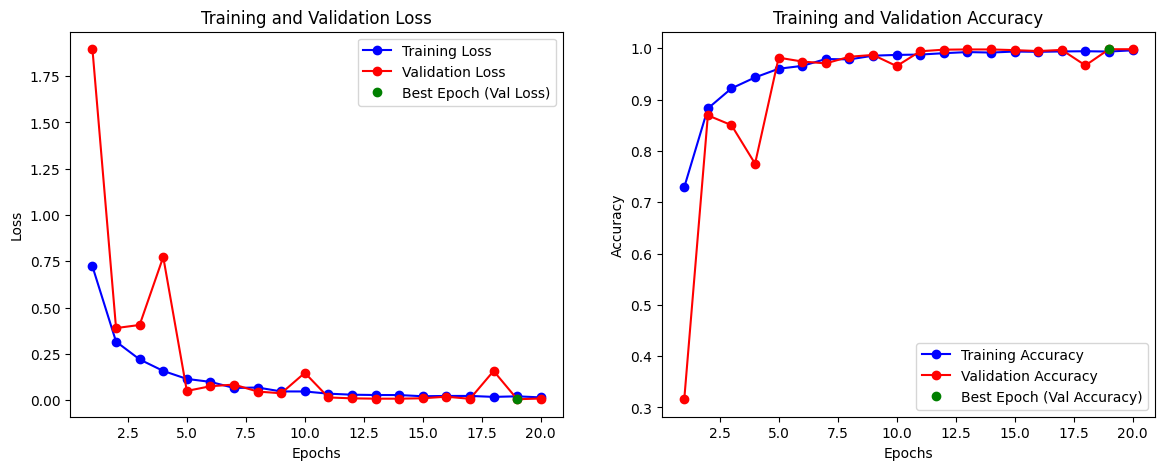

In [ ]:
print_performance(EfficientNetB3_model_lung_history)

In [ ]:
print_evaluation(EfficientNetB3_model_lung, train_gen_lung, valid_gen_lung, test_gen_lung)

71/71 [==============================] - 11s 151ms/step - loss: 0.0098 - accuracy: 0.9973
Train Loss:  0.0001373960403725505
Train Accuracy:  0.9999047517776489
--------------------
Validation Loss:  0.008820482529699802
Validation Accuracy:  0.9982222318649292
--------------------
Test Loss:  0.009797533042728901
Test Accuracy:  0.9973333477973938


71/71 [==============================] - 14s 147ms/step


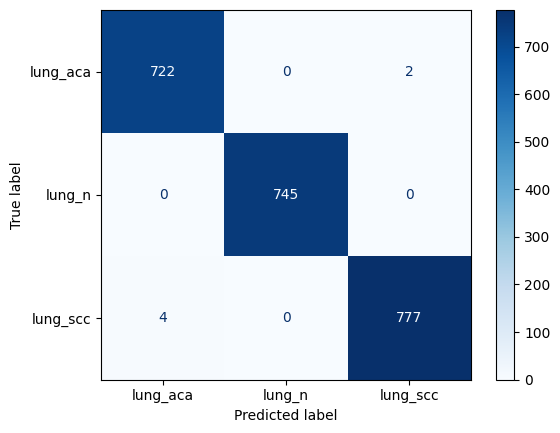

In [ ]:
print_confusion_matrix(EfficientNetB3_model_lung, test_gen_lung)

In [ ]:
print(classification_report(test_gen_lung.classes, np.argmax(EfficientNetB3_model_lung.predict(test_gen_lung), axis=1), target_names= list(test_gen_lung.class_indices.keys())))

71/71 [==============================] - 12s 172ms/step
              precision    recall  f1-score   support

    lung_aca       0.99      1.00      1.00       724
      lung_n       1.00      1.00      1.00       745
    lung_scc       1.00      0.99      1.00       781

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [ ]:
EfficientNetB3_model_lung.save("/content/lung_colon_images/EfficientNetB3_model_lung.keras")

In [18]:
ResNet50_model_lung_base = ResNet50V2(input_shape=(224, 224, 3), weights ='imagenet', include_top=False)

Freeze layers

In [19]:
for layer in ResNet50_model_lung_base.layers:
  layer.trainable = False

In [22]:
x = ResNet50_model_lung_base.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(list(train_gen_lung.class_indices.keys())), activation='softmax')(x)

In [23]:
ResNet50_model_lung = Model(inputs = ResNet50_model_lung_base.input, outputs = predictions)
ResNet50_model_lung.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [25]:
ResNet50_model_lung.compile(optimizer = Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])
ResNet50_model_lung_history = ResNet50_model_lung.fit(train_gen_lung, epochs = 20, verbose = 1, validation_data = valid_gen_lung)

Epoch 1/20
329/329 [==============================] - 72s 202ms/step - loss: 0.3421 - accuracy: 0.8755 - val_loss: 0.2270 - val_accuracy: 0.9360
Epoch 2/20
329/329 [==============================] - 61s 187ms/step - loss: 0.1735 - accuracy: 0.9375 - val_loss: 0.1462 - val_accuracy: 0.9493
Epoch 3/20
329/329 [==============================] - 62s 188ms/step - loss: 0.1356 - accuracy: 0.9507 - val_loss: 0.1191 - val_accuracy: 0.9609
Epoch 4/20
329/329 [==============================] - 72s 217ms/step - loss: 0.1086 - accuracy: 0.9630 - val_loss: 0.1036 - val_accuracy: 0.9644
Epoch 5/20
329/329 [==============================] - 64s 194ms/step - loss: 0.0968 - accuracy: 0.9658 - val_loss: 0.0933 - val_accuracy: 0.9676
Epoch 6/20
329/329 [==============================] - 61s 186ms/step - loss: 0.0839 - accuracy: 0.9693 - val_loss: 0.0836 - val_accuracy: 0.9716
Epoch 7/20
329/329 [==============================] - 63s 191ms/step - loss: 0.0723 - accuracy: 0.9759 - val_loss: 0.0770 - val_ac

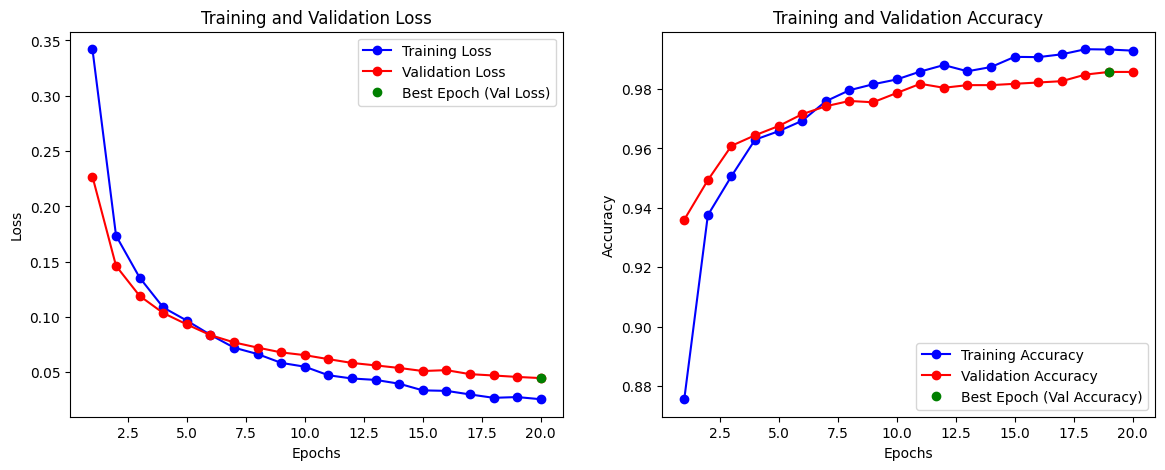

In [29]:
print_performance(ResNet50_model_lung_history)

In [32]:
print_evaluation(ResNet50_model_lung, train_gen_lung, valid_gen_lung, test_gen_lung)

71/71 [==============================] - 12s 164ms/step - loss: 0.0487 - accuracy: 0.9840
Train Loss:  0.013593357987701893
Train Accuracy:  0.9987618923187256
--------------------
Validation Loss:  0.04479595273733139
Validation Accuracy:  0.9857777953147888
--------------------
Test Loss:  0.048652783036231995
Test Accuracy:  0.984000027179718


71/71 [==============================] - 12s 162ms/step


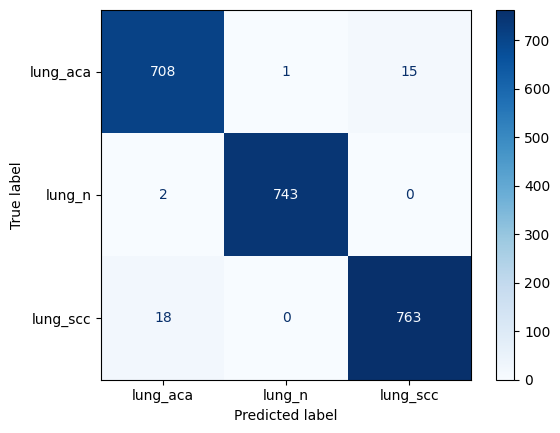

In [33]:
print_confusion_matrix(ResNet50_model_lung, test_gen_lung)

In [34]:
print(classification_report(test_gen_lung.classes, np.argmax(ResNet50_model_lung.predict(test_gen_lung), axis=1), target_names= list(test_gen_lung.class_indices.keys())))

71/71 [==============================] - 11s 159ms/step
              precision    recall  f1-score   support

    lung_aca       0.97      0.98      0.98       724
      lung_n       1.00      1.00      1.00       745
    lung_scc       0.98      0.98      0.98       781

    accuracy                           0.98      2250
   macro avg       0.98      0.98      0.98      2250
weighted avg       0.98      0.98      0.98      2250



In [49]:
base_model_colon = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='none')
x = base_model_colon.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(list(train_gen_colon.class_indices.keys())), activation='softmax')(x)

In [50]:
for layer in base_model_colon.layers:
    layer.trainable = False

In [51]:
EfficientNetB3_model_colon = Model(inputs = base_model_colon.input, outputs = predictions)

In [54]:
EfficientNetB3_model_colon.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
EfficientNetB3_model_colon.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_3[0][0]'

In [55]:
EfficientNetB3_model_lung_history = EfficientNetB3_model_colon.fit(train_gen_colon, epochs = 15, verbose = 1, validation_data = valid_gen_colon)

Epoch 1/15
219/219 [==============================] - 61s 226ms/step - loss: 0.8049 - accuracy: 0.5243 - val_loss: 0.6865 - val_accuracy: 0.5740
Epoch 2/15
219/219 [==============================] - 50s 229ms/step - loss: 0.7205 - accuracy: 0.5807 - val_loss: 0.6619 - val_accuracy: 0.7093
Epoch 3/15
219/219 [==============================] - 46s 208ms/step - loss: 0.6743 - accuracy: 0.6159 - val_loss: 0.6254 - val_accuracy: 0.7420
Epoch 4/15
219/219 [==============================] - 50s 227ms/step - loss: 0.6662 - accuracy: 0.6241 - val_loss: 0.6046 - val_accuracy: 0.7580
Epoch 5/15
219/219 [==============================] - 50s 226ms/step - loss: 0.6333 - accuracy: 0.6564 - val_loss: 0.5922 - val_accuracy: 0.7620
Epoch 6/15
219/219 [==============================] - 49s 224ms/step - loss: 0.6340 - accuracy: 0.6503 - val_loss: 0.5880 - val_accuracy: 0.7560
Epoch 7/15
219/219 [==============================] - 47s 213ms/step - loss: 0.6150 - accuracy: 0.6630 - val_loss: 0.5847 - val_ac

In [56]:
for layer in base_model_colon.layers[-50:]:
    layer.trainable = True

In [57]:
EfficientNetB3_model_colon.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EfficientNetB3_model_colon_history = EfficientNetB3_model_colon.fit(train_gen_colon, epochs = 5, verbose = 1, validation_data = valid_gen_colon)

Epoch 1/5
219/219 [==============================] - 70s 245ms/step - loss: 0.8702 - accuracy: 0.6017 - val_loss: 0.8900 - val_accuracy: 0.4867
Epoch 2/5
219/219 [==============================] - 48s 218ms/step - loss: 0.6983 - accuracy: 0.6400 - val_loss: 0.6524 - val_accuracy: 0.5353
Epoch 3/5
219/219 [==============================] - 53s 242ms/step - loss: 0.6539 - accuracy: 0.6540 - val_loss: 0.6720 - val_accuracy: 0.5627
Epoch 4/5
219/219 [==============================] - 49s 222ms/step - loss: 0.6131 - accuracy: 0.6729 - val_loss: 0.5488 - val_accuracy: 0.7253
Epoch 5/5
219/219 [==============================] - 49s 222ms/step - loss: 0.5933 - accuracy: 0.6873 - val_loss: 0.5570 - val_accuracy: 0.7060


# ResNet50V2 Colon cancer detection

In [ ]:
ResNet50_model_colon_base = ResNet50V2(input_shape=(224, 224, 3), weights ='imagenet', include_top=False)

In [ ]:
for layer in ResNet50_model_colon_base.layers:
  layer.trainable = False

x = ResNet50_model_colon_base.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(list(train_gen_lung.class_indices.keys())), activation='softmax')(x)

In [ ]:
ResNet50_model_colon = Model(inputs = ResNet50_model_colon_base.input, outputs = predictions)
ResNet50_model_colon.summary()

In [ ]:
ResNet50_model_colon.compile(optimizer = Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])
ResNet50_model_colon_history = ResNet50_model_colon.fit(train_gen_colon, epochs = 20, verbose = 1, validation_data = valid_gen_colon)

In [ ]:
print_performance(ResNet50_model_lung_history)

In [ ]:
print_evaluation(ResNet50_model_lung, train_gen_lung, valid_gen_lung, test_gen_lung)

In [ ]:
print_confusion_matrix(ResNet50_model_lung, test_gen_lung)